<a href="https://colab.research.google.com/github/Thehunk1206/Arduino-Surrounding-Sound-Classifier/blob/master/audio_classifier_for_mcu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Classifier for Micro Controller Unit (here: Arduino Nano BLE Sense)

In [1]:
%cd drive/MyDrive/audio_classifier_mcu/

/content/drive/MyDrive/audio_classifier_mcu


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Importing stuff

In [34]:
import os
import glob


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models


tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
# seed = 102
# tf.random.set_seed(seed)
# np.random.seed(seed)

## Some Constants

In [14]:
# Audio related
SAMPLE_RATE = 16000
FRAME_SIZE_MS = 30 
FRAME_STRIDE_MS = 20

FRAME_SIZE = int(SAMPLE_RATE*(FRAME_SIZE_MS/1000))
FRAME_STRIDE = int(SAMPLE_RATE*(FRAME_STRIDE_MS/1000))
TAKE_MEAN_AT_INTERVAL = 6

#ML related
DATA_DIR = 'Dataset/'
BATCH_SIZE = 32
LR = 2e-3
EPOCHS = 50
KERAS_MODEL = 'audio_classifier_float.h5'
FLOAT_TFLITE_MODEL = 'float_tflite_model.tflite'
INTONLY_QUANT_TFLITE_MODEL = 'intonly_quant_tflite_model.tflite'

## Splitting Dataset Files

In [4]:
LABELS = np.array(os.listdir(DATA_DIR))
LABEL_IDS = [i for i in range(len(LABELS))]
LABEL_ONE_HOT = tf.one_hot(LABEL_IDS, len(LABELS), axis=-1)

def audio_datasets_path(data_dir: str, train_split: float = 0.7, val_split: float= 0.1, test_split:float = 0.2):
    all_audio_filenames = glob.glob(data_dir+"/*/*")
    all_audio_filenames = tf.random.shuffle(all_audio_filenames)

    train = all_audio_filenames[0:int(len(all_audio_filenames)*train_split)]
    val = all_audio_filenames[len(train):len(train)+int(len(all_audio_filenames)*val_split)]
    test = all_audio_filenames[-int(len(all_audio_filenames)*test_split):]

    return train, val, test

LABELS

array(['BACKGROUND', 'FAN', 'WHISTLE'], dtype='<U10')

In [5]:
train_audio_files, val_audio_files, test_audio_files = audio_datasets_path(DATA_DIR)

## Reading Raw Audio and Label

In [6]:
def get_label(audio_file_path: str):
    string_parts = tf.strings.split(audio_file_path, os.path.sep)
    return string_parts[-2]


def get_waveform_from_audio_file(audio_file:str):
    '''
    The audio is of 16-bit PCM i.e values ranging from -32768 to 32767
    tf.audio.decode_wav normalizes the data between [-1.0,1.0]
    '''
    audio_binary = tf.io.read_file(audio_file)
    audio_raw, _ = tf.audio.decode_wav(audio_binary,desired_channels=1)
    return tf.squeeze(audio_raw, axis=-1)


def get_waveform_and_label(audio_file:str):
    label = get_label(audio_file)
    waveform = get_waveform_from_audio_file(audio_file)

    return waveform, label


## Creating Spectogram from Raw Audio

In [7]:
def get_spectrogram_from_raw_audio(waveform: tf.Tensor, frame_size:int = 256, frame_stride:int=128):
    '''
    Zero padding tha waveform to sampling Rate in case some file have less than 1600 values
    '''
    zero_padding = tf.zeros([SAMPLE_RATE] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length_of_waveform = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length_of_waveform, frame_length=frame_size, frame_step=frame_stride)

    spectrogram = tf.abs(spectrogram)

    return spectrogram


def get_spectrogram_and_label(waveform: tf.Tensor, label: str):
    '''
    Get both spectrogram and corresponding label_id
    '''
    spectrogram = get_spectrogram_from_raw_audio(waveform,frame_size=FRAME_SIZE, frame_stride=FRAME_STRIDE)
    # spectrogram = tf.py_function(get_averaged_column_spectrtogram, [spectrogram], [tf.float32])
    spectrogram = tf.expand_dims(spectrogram, -1)
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, axis=1),
        window_shape = [1,TAKE_MEAN_AT_INTERVAL],
        strides = [1,TAKE_MEAN_AT_INTERVAL],
        pooling_type='AVG',
        padding='VALID'
    )
    spectrogram = tf.squeeze(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == LABELS)
    label = LABEL_ONE_HOT[label_id]

    return spectrogram, label

## Creating Data Pipeline using tf.data

In [8]:
def preprocess_data(audio_files: tf.Tensor):
    audio_files_ds = tf.data.Dataset.from_tensor_slices(audio_files)
    output_waveform_ds = audio_files_ds.map(
        get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE
    )
    output_spectrogram_ds = output_waveform_ds.map(
        get_spectrogram_and_label, num_parallel_calls = tf.data.AUTOTUNE
    )
    output_spectrogram_ds.shuffle(buffer_size=300)
    output_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

    return output_spectrogram_ds

train_ds = preprocess_data(train_audio_files)
val_ds = preprocess_data(val_audio_files)
test_ds = preprocess_data(test_audio_files)

In [9]:
for spectrogram,label in train_ds.take(1):
    print(spectrogram.shape)

(49, 42, 1)


## Plotting Spectrograms with label

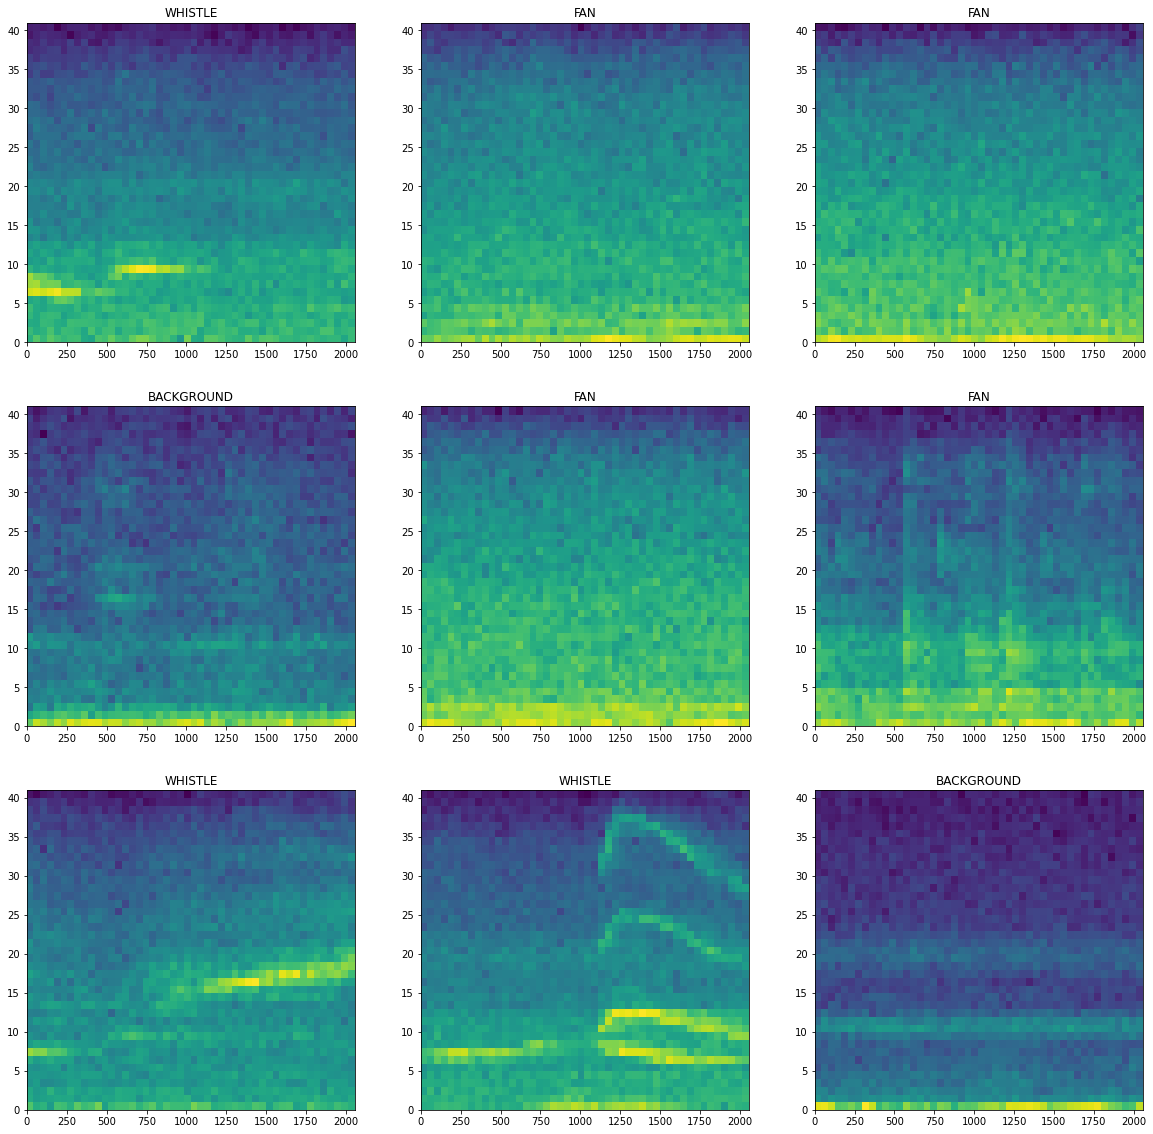

In [10]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
for i, (spectrogram, label) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(LABELS[tf.argmax(label)])
#   ax.axis('off')

plt.show()

## Model creating and training
 

### Keras Model 

In [ ]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# Get inputshape of spectrogram
for spectrogram,_ in train_ds.take(1):
    spectrogram_shape = spectrogram.shape
print(f'Input shape:{spectrogram.shape}')
num_of_labels = len(LABELS)

Input shape:(32, 49, 42, 1)


In [ ]:
# Create a simple CNN 
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(spectrogram_shape[1],spectrogram_shape[2],1)))
model.add(layers.Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(16, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(num_of_labels, activation='softmax', name='y_pred'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 49, 42, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 21, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 21, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 21, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 11, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 11, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2288)             

### Model compiling and Training

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy'],
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=KERAS_MODEL,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds,callbacks=model_checkpoint_callback)

Epoch 1/50
58/58 [==============================] - 1075s 19s/step - loss: 0.4922 - accuracy: 0.8018 - val_loss: 0.1752 - val_accuracy: 0.9470
Epoch 2/50
58/58 [==============================] - 32s 559ms/step - loss: 0.2516 - accuracy: 0.9174 - val_loss: 0.1451 - val_accuracy: 0.9583
Epoch 3/50
58/58 [==============================] - 33s 562ms/step - loss: 0.2268 - accuracy: 0.9222 - val_loss: 0.1241 - val_accuracy: 0.9697
Epoch 4/50
58/58 [==============================] - 32s 551ms/step - loss: 0.1944 - accuracy: 0.9352 - val_loss: 0.0891 - val_accuracy: 0.9773
Epoch 5/50
58/58 [==============================] - 32s 555ms/step - loss: 0.1662 - accuracy: 0.9476 - val_loss: 0.0801 - val_accuracy: 0.9735
Epoch 6/50
58/58 [==============================] - 32s 552ms/step - loss: 0.1610 - accuracy: 0.9487 - val_loss: 0.0833 - val_accuracy: 0.9735
Epoch 7/50
58/58 [==============================] - 32s 555ms/step - loss: 0.1512 - accuracy: 0.9519 - val_loss: 0.0655 - val_accuracy: 0.9773

### Plotting loss and accuracy over epochs

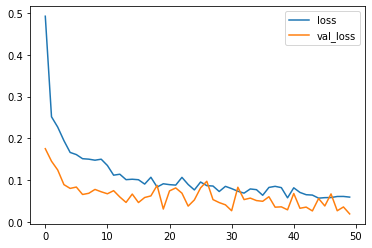

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

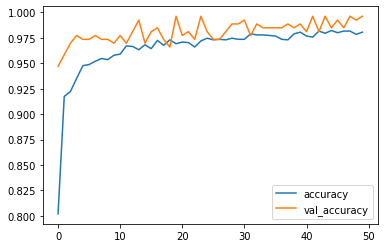

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Model Testing

In [15]:
model = models.load_model(KERAS_MODEL)

In [19]:
test_ds = test_ds.batch(1)
model_test_score = model.evaluate(test_ds)

529/529 [==============================] - 286s 541ms/step - loss: 0.0557 - accuracy: 0.9811


## Quantization of Model

### Converting keras h5 model to tflite float model


In [21]:
model = models.load_model(KERAS_MODEL)

converter_for_float = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter_for_float.convert()
size_of_float_model = open(FLOAT_TFLITE_MODEL, 'wb').write(tflite_float_model)
print(f'Total size of {FLOAT_TFLITE_MODEL} is {size_of_float_model}')

INFO:tensorflow:Assets written to: /tmp/tmp40vqu14x/assets
Total size of float_tflite_model.tflite is 35300


In [22]:
float_interpreter = tf.lite.Interpreter(model_content=tflite_float_model)
input_type = float_interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = float_interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


### Converting keras h5 model to tflite Integer-only quantized model for Microcontroller unit
> 1. Create a representative dataset to calibarate variable data.
> 2. Set the dtype of input and output of model to tf.int8

In [23]:
def representative_data_gen():
    for input_spec,_ in train_ds.batch(1).take(300):
        yield [input_spec] 

In [25]:
converter_int_model = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int_model.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int_model.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter_int_model.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int_model.inference_input_type = tf.uint8
converter_int_model.inference_output_type = tf.uint8

tflite_model_intonly_quant = converter_int_model.convert()
size_of_intonly_model = open(INTONLY_QUANT_TFLITE_MODEL, 'wb').write(tflite_model_intonly_quant)
print(f'Total size of {INTONLY_QUANT_TFLITE_MODEL} is {size_of_intonly_model}')

INFO:tensorflow:Assets written to: /tmp/tmpvjg5t9zf/assets


INFO:tensorflow:Assets written to: /tmp/tmpvjg5t9zf/assets


Total size of intonly_quant_tflite_model.tflite is 12392


In [26]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_intonly_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


### Testing tflite intonly quantized model

In [39]:
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=INTONLY_QUANT_TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

correct_predictions = 0
i = 0
for i,(spec,label) in tqdm(enumerate(test_ds.batch(1))):
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      spec = spec.numpy()
      spec = spec / input_scale + input_zero_point
    spec = spec.astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], spec)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == np.argmax(label.numpy()[0]))
print('\nInt-only Quant model accuracy is %f%% (Number of test samples=%d)' % ((correct_predictions * 100) / i+1, i+1))

529it [00:10, 52.04it/s]


Int-only Quant model accuracy is 97.022727% (Number of test samples=529)
